<a href="https://colab.research.google.com/github/msa-1988/StockForecast_RNN_GRU_LSTM/blob/main/StockForecast_RNN_GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Stock Price Forecasting with RNN, GRU, and LSTM Models

Introduction:
This Colab notebook presents a project focused on stock price forecasting using various recurrent neural network (RNN) architectures, including RNN, GRU, and LSTM models. The project utilizes historical Amazon stock data to train, evaluate, and compare the performance of these models in predicting future stock prices.

The main objective of this project is to explore the capabilities of different RNN architectures in capturing temporal patterns and making accurate predictions in the dynamic and volatile domain of stock market forecasting. By implementing and analyzing multiple models, we aim to gain insights into their strengths, weaknesses, and suitability for stock price prediction tasks.

Key Features:

Model Design: The notebook provides detailed implementations of RNN, GRU, and LSTM models using popular deep learning framework, PyTorch. These models are designed to effectively learn from sequential data and capture complex temporal dependencies in stock price movements.

Training and Evaluation: The project includes training procedures for each model using historical Amazon stock data. The trained models are then evaluated using appropriate evaluation metrics to assess their predictive performance and generalization capabilities.

Model Comparison: The notebook offers a comparative analysis of the trained models, showcasing their forecasting accuracy and highlighting any distinct advantages or limitations of each architecture. This comparison helps in understanding the trade-offs between model complexity, training time, and prediction accuracy.

Dataset: The project employs historical Amazon stock data as the primary dataset. The dataset contains a rich collection of features and historical price information, enabling the models to learn from past trends and patterns to predict future stock prices.

We hope that this Colab notebook will serve as a useful resource for those interested in stock price forecasting and exploring the capabilities of RNN, GRU, and LSTM models. By following the implementations, training procedures, and comparative analysis provided, users can gain insights into the performance and applicability of these models for stock market prediction tasks.

Note: It is important to acknowledge that stock price forecasting is a complex and highly unpredictable task. The models presented in this notebook should be used for educational and research purposes only and should not be considered as financial advice or recommendations for actual trading decisions.

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
import torch as tr
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.autograd.grad_mode import no_grad
# device = 'cuda:0' if tr.cuda.is_available else 'cpu'
device = 'cpu'
print(device)




cpu


In [236]:
## Hyper parameters
learning_rate = 0.001
num_epochs = 10
criterion = nn.MSELoss()

In [237]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataScience/AMZN.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [238]:
## Get Date and Closing data
df = data[["Date","Close"]]
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


In [239]:
## Sort values by Date
df = df.sort_values(by="Date")
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


<Axes: >

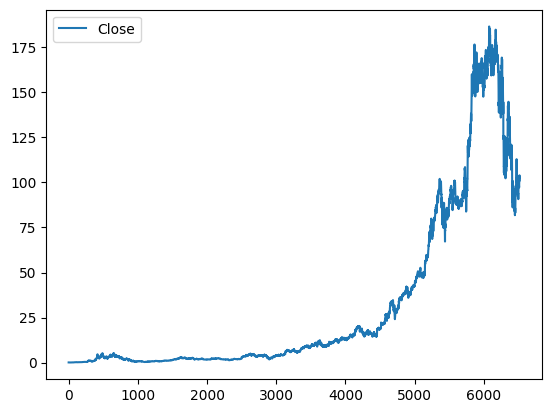

In [240]:
## Get only the Close stock values. We will be forcasting this value
df = df[["Close"]]
df.plot()

In [241]:
def prepareData(df,shiftLen):
  for i in range(shiftLen):
    df[f"t-{i+1}"] = df["Close"].shift(-i)
  return df

shiftLen = 7
df1 = prepareData(df,shiftLen)
df1.dropna(inplace=True)
df1.head()

,Close,t-1,t-2,t-3,t-4,t-5,t-6,t-7
0,0.097917,0.097917,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000
1,0.086458,0.086458,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167
2,0.085417,0.085417,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563
3,0.081771,0.081771,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260
4,0.071354,0.071354,0.069792,0.075000,0.079167,0.076563,0.075260,0.075000


In [242]:
#Normalize
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

df2 = sc.fit_transform(df1)


In [243]:
print(df2)

[[-0.99969839 -0.99969839 -0.99982128 ... -0.99998325 -1.
  -0.99995531]
 [-0.99982128 -0.99982128 -0.99983244 ... -1.         -0.99994415
  -0.99991063]
 [-0.99983244 -0.99983244 -0.99987154 ... -0.99994415 -0.99989946
  -0.99993855]
 ...
 [ 0.05158     0.05158     0.0506149  ...  0.09308121  0.10691495
   0.09747299]
 [ 0.0506149   0.0506149   0.04203581 ...  0.10691495  0.09747802
   0.11398769]
 [ 0.04203581  0.04203581  0.07431453 ...  0.09747802  0.11399263
   0.08342464]]


In [244]:
## Separate input and target data
X = df2[:,1:]
y = df2[:,0]



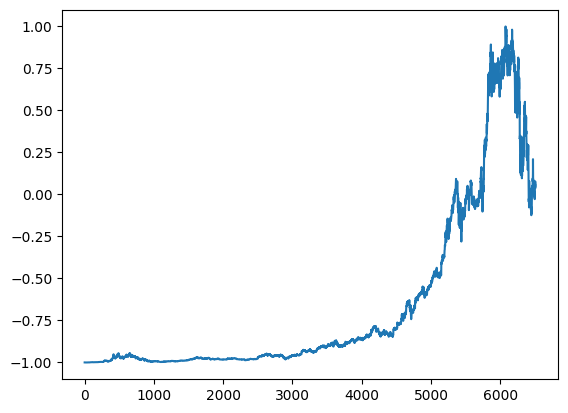

In [245]:
import matplotlib.pyplot as plt
plt.plot(y)

In [246]:
## Flit the input data horizontally to align with model input: t-7,t-6,...t-1
X = np.flip(X, axis=1)

In [247]:
print(X.shape, y.shape)

(6510, 7) (6510,)


In [248]:
# from sklearn.model_selection import train_test_split

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

# print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

In [249]:
## split into train and test data
splitIndex = int(len(X)*0.9)
X_train,X_test,y_train,y_test = X[0:splitIndex],X[splitIndex:],y[0:splitIndex],y[splitIndex:]

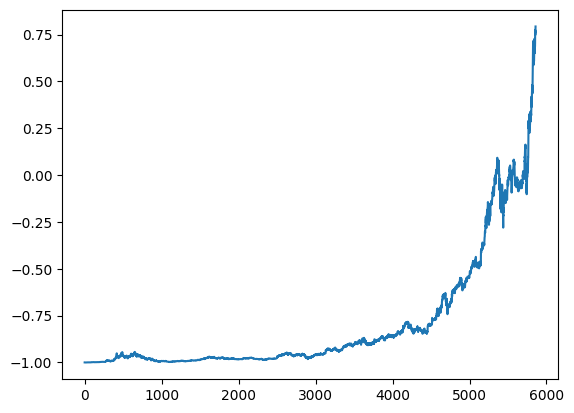

In [250]:
plt.plot(y_train)

In [251]:


X_train_tensor = tr.tensor(X_train.copy()).float()
X_test_tensor = tr.tensor(X_test.copy()).float()
y_train_tensor = tr.tensor(y_train.copy()).float()
y_test_tensor = tr.tensor(y_test.copy()).float()

print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)


torch.Size([5859, 7]) torch.Size([651, 7]) torch.Size([5859]) torch.Size([651])


In [252]:
X_train_tensor = X_train_tensor.reshape((-1,shiftLen,1))
X_test_tensor = X_test_tensor.reshape((-1,shiftLen,1))
y_train_tensor = y_train_tensor.reshape((-1,1))
y_test_tensor = y_test_tensor.reshape((-1,1))

print(X_train_tensor.shape, X_test_tensor.shape,y_train_tensor.shape,y_test_tensor.shape)

torch.Size([5859, 7, 1]) torch.Size([651, 7, 1]) torch.Size([5859, 1]) torch.Size([651, 1])


In [253]:
from torch.utils.data import Dataset

class customDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i],self.y[i]


train_dataset = customDataset(X_train_tensor,y_train_tensor)
test_dataset = customDataset(X_test_tensor,y_test_tensor)


In [254]:
train_dataset

In [255]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [256]:
for _, batch in enumerate(train_loader):
  x_batch,y_batch = batch[0],batch[1]
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [257]:
## Create myLSTM model
class myLSTM(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers =num_layers
    self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
    self.l1 = nn.Linear(self.hidden_size,1)

  def forward(self,x):

    h0 = tr.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    c0 = tr.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

    x,_ = self.lstm(x,(h0,c0))
    x =self.l1(x[:,-1,:])
    return x



In [258]:
## Create myGRU model
class myGRU(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers =num_layers
    self.gru = nn.GRU(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
    self.l1 = nn.Linear(self.hidden_size,1)

  def forward(self,x):

    h0 = tr.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    x,_ = self.gru(x,h0)
    x =self.l1(x[:,-1,:])
    return x



In [259]:
## Create myRNN model
class myRNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers =num_layers
    self.rnn = nn.RNN(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
    self.l1 = nn.Linear(self.hidden_size,1)

  def forward(self,x):

    h0 = tr.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

    x,_ = self.rnn(x,h0)
    x =self.l1(x[:,-1,:])
    return x



In [260]:

def train_one_epoch(model,trainEpoch):
  model.train(True)
  print(f"Training epoch ({trainEpoch+1})")
  running_loss = 0

  for i,batch in enumerate(train_loader):
    X_batch,y_batch = batch[0].to(device),batch[1].to(device)

    output = model(X_batch)
    loss = criterion(output,y_batch)
    running_loss+=loss.item()
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1)%100==99:
      print(f"Training batch ({i+1}); loss = {running_loss/100}")
      running_loss=0

def validate_one_epoch(model,validateEpoch):
    model.train(False)
    print(f"Validate epoch ({validateEpoch+1})")
    running_loss = 0.0


    for i,batch in enumerate(test_loader):
      X_batch,y_batch = batch[0].to(device),batch[1].to(device)
      with tr.no_grad():
        output = model(X_batch)
        loss = criterion(output,y_batch)
        running_loss+=loss.item()
    print(f"Validate loss = {running_loss/len(test_loader)}")
    print("********************************************")





In [261]:
# Create instances of the model

model_rnn = myRNN(1, 7, 5)
model_gru = myGRU(1, 7, 5)
model_lstm = myLSTM(1, 7, 10)

model_names = [model_rnn, model_gru, model_lstm]
models = [myRNN(1, 7, 4), myGRU(1, 7, 4), myLSTM(1, 7, 4)]
# Define a list to store the evaluation results
evaluation_results = []


# Training loop
for model in model_names:
    print(model,"\n")

    optim = tr.optim.Adam(model.parameters(), lr=learning_rate)
    # Training and validating each epoch code here
    for epoch in range(num_epochs):
      train_one_epoch(model,epoch)
      validate_one_epoch(model, epoch)


myRNN(
  (rnn): RNN(1, 7, num_layers=5, batch_first=True)
  (l1): Linear(in_features=7, out_features=1, bias=True)
) 

Training epoch (1)
Training batch (99); loss = 0.1221040921472013
Training batch (199); loss = 0.027325887898914516
Training batch (299); loss = 0.004621998487273231
Validate epoch (1)
Validate loss = 0.19564710850770609
********************************************
Training epoch (2)
Training batch (99); loss = 0.0019104101513221395
Training batch (199); loss = 0.0008752583110981505
Training batch (299); loss = 0.0007453407074899587
Validate epoch (2)
Validate loss = 0.043074838980384986
********************************************
Training epoch (3)
Training batch (99); loss = 0.0004376901108389575
Training batch (199); loss = 0.0003494461494665302
Training batch (299); loss = 0.0002694459169106267
Validate epoch (3)
Validate loss = 0.028003483303686287
********************************************
Training epoch (4)
Training batch (99); loss = 0.0003289429566484614
Tr

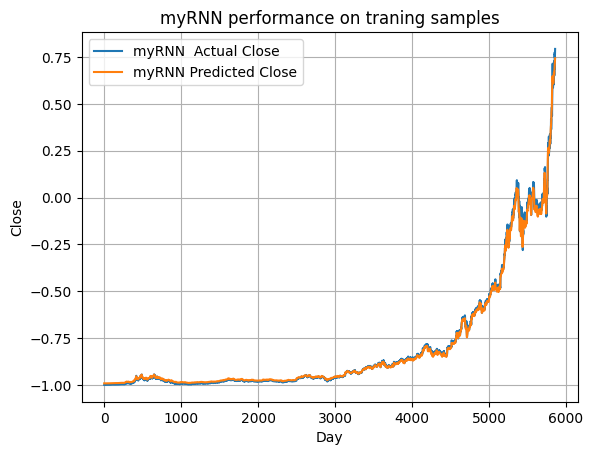

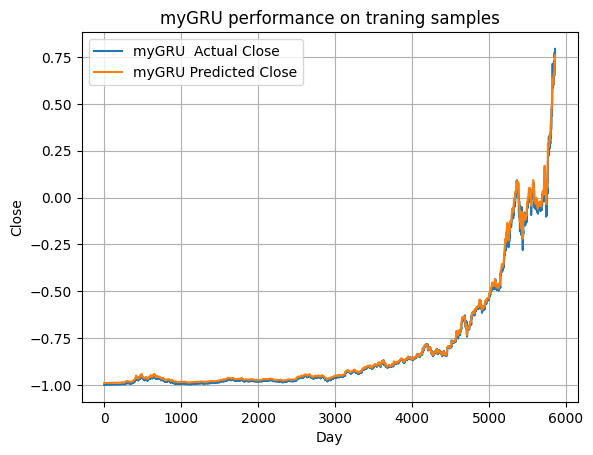

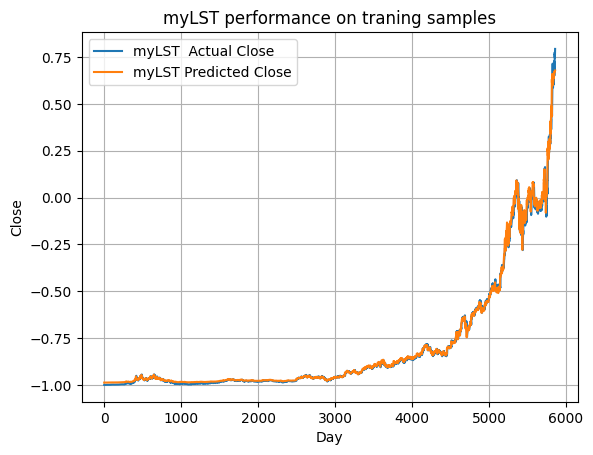

In [262]:

### Plot train and prediction
for model in model_names:
    with tr.no_grad():
        predicted = model(X_train_tensor.to(device)).to('cpu').numpy()

    plt.figure()
    plt.plot(y_train_tensor, label=str(model)[0:5]+'  Actual Close')
    plt.plot(predicted, label=str(model)[0:5]+' Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title(str(model)[0:5]+" performance on traning samples")
    plt.legend()
    plt.grid()
    plt.show()


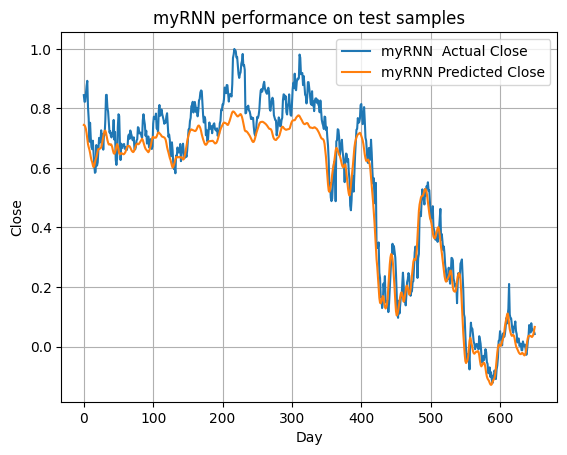

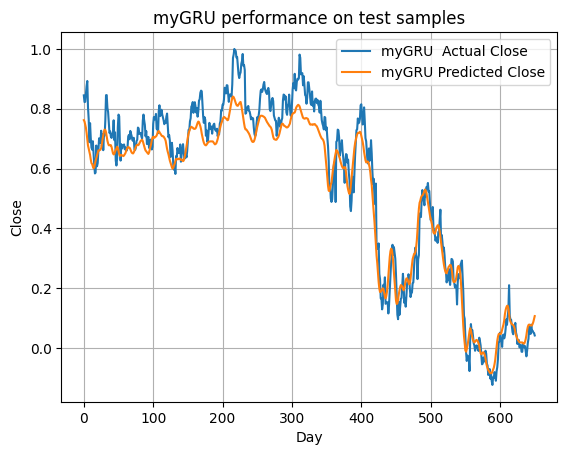

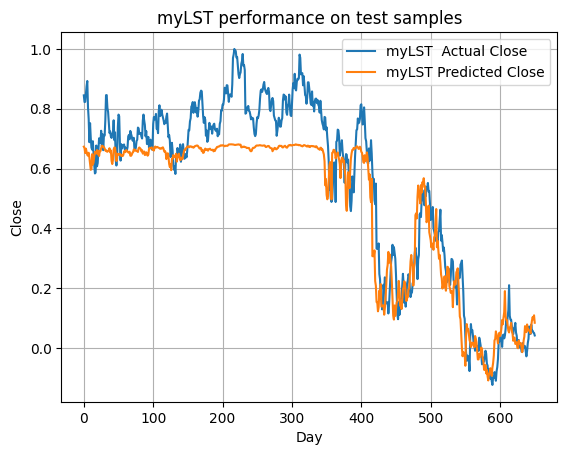

In [263]:

### Plot test and prediction
for model in model_names:
    with tr.no_grad():
        predicted = model(X_test_tensor.to(device)).to('cpu').numpy()

    plt.figure()
    plt.plot(y_test_tensor, label=str(model)[0:5]+'  Actual Close')
    plt.plot(predicted, label=str(model)[0:5]+' Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title(str(model)[0:5]+" performance on test samples")
    plt.legend()
    plt.grid()
    plt.show()


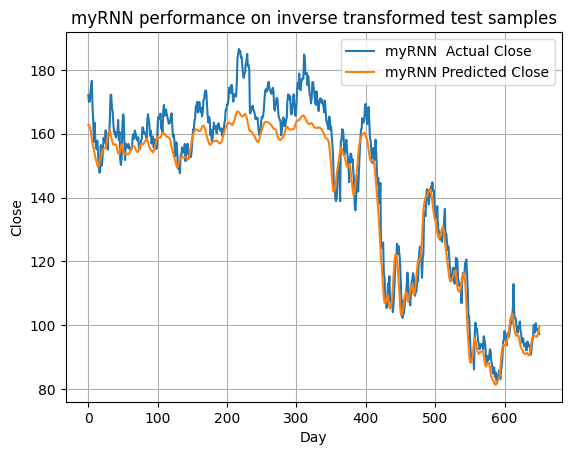

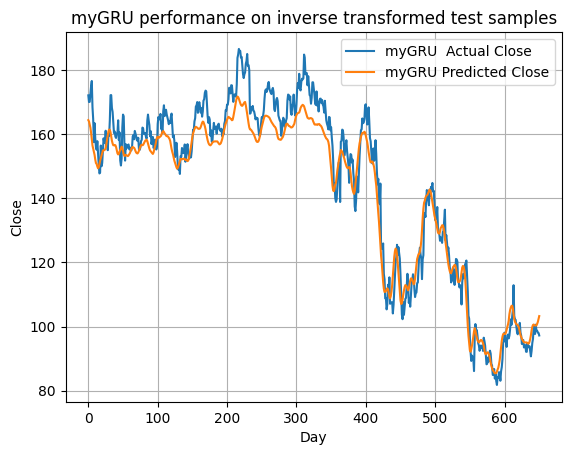

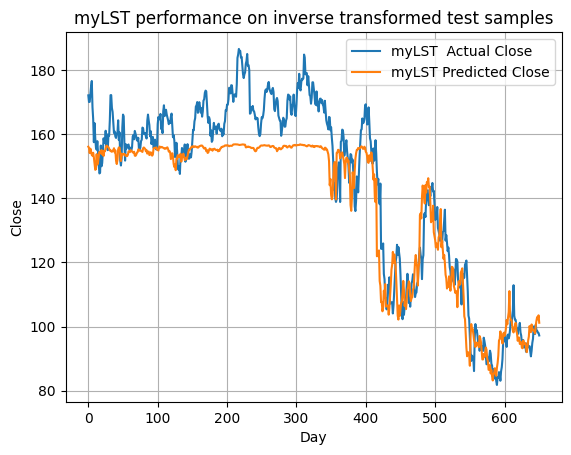

In [264]:

### Plot test and prediction of the inverse transform of the normalization
for model in model_names:
    with tr.no_grad():
        y_test_pred = model(X_test_tensor.to(device)).to('cpu').numpy()


    X_test2 = X_test_tensor.to('cpu').numpy().reshape(-1,7)

    X_test3 = np.hstack((y_test_pred,np.flip(X_test2, axis=1)))## prediction
    X_test4 = np.hstack((y_test_tensor.to('cpu').numpy().reshape(-1,1),np.flip(X_test2, axis=1)))### Actual
## Inverse transform
    X_test31 = sc.inverse_transform(X_test3)##inverser transform of prediciton
    X_test41 = sc.inverse_transform(X_test4)#inverse transformed actual

    plt.figure()
    plt.plot(X_test41[:,0], label=str(model)[0:5]+'  Actual Close')
    plt.plot(X_test31[:,0], label=str(model)[0:5]+' Predicted Close')
    plt.title(str(model)[0:5]+" performance on inverse transformed test samples")
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.grid()
    plt.show()


50


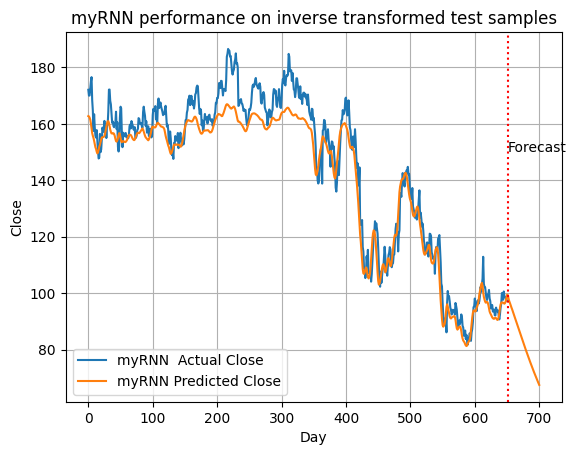

50


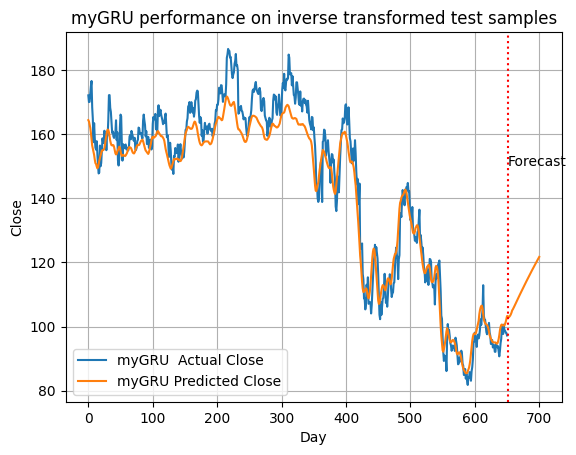

50


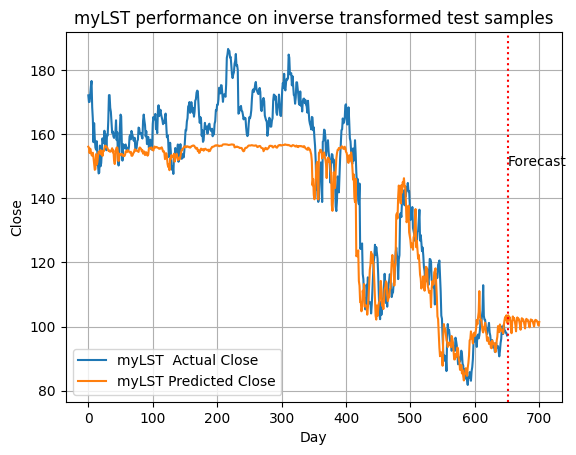

In [265]:

### Plot test and prediction of the inverse transform of the normalization
future_steps = 50  # Adjust this value according to your needs
for model in model_names:
    with tr.no_grad():
        y_test_pred = model(X_test_tensor.to(device)).to('cpu').numpy()


        last_sequence = X_test_tensor[-1:]
        # print("last_sequence \n ",last_sequence.shape)

        # Generate future predictions by feeding the model with the last sequence
        for _ in range(future_steps):
            y_pred_future = model(last_sequence.to(device))

            # Append the predicted value to the forecasts list
            y_test_pred = np.concatenate((y_test_pred, y_pred_future))

            # Update the last sequence by removing the oldest value and adding the predicted value
            last_sequence = tr.cat((last_sequence[:, 1:, :], y_pred_future.unsqueeze(0)),dim=1)


    X_test2 = X_test_tensor.to('cpu').numpy().reshape(-1,7)
    X_test4 = np.hstack((y_test_tensor.to('cpu').numpy().reshape(-1,1),np.flip(X_test2, axis=1)))### Actual

    # Pad array1 with zeros to match the size of array2
    pad_size = future_steps#len(y_test_pred) - len(X_test2)
    print(pad_size)
    X_test2 = np.pad(X_test2, ((0, pad_size),(0, 0)), 'constant')
    X_test3 = np.hstack((y_test_pred,np.flip(X_test2, axis=1)))## prediction

## Inverse transform
    X_test31 = sc.inverse_transform(X_test3)##inverser transform of prediciton
    X_test41 = sc.inverse_transform(X_test4)#inverse transformed actual

    plt.figure()
    plt.plot(X_test41[:,0], label=str(model)[0:5]+'  Actual Close')
    plt.plot(X_test31[:,0], label=str(model)[0:5]+' Predicted Close')
    # Plot a vertical line at len(X_test2)
    plt.axvline(x=len(X_test2)-pad_size, linestyle='dotted', color='red')
    # Annotate the line
    # plt.annotate('Forecast', xy=(len(X_test2)-pad_size, 0), xytext=(len(X_test2)-pad_size+5, 0), color='red', xycoords='data', textcoords='offset points', ha='left', va='center')
    plt.text(len(X_test2)-pad_size,150, 'Forecast')

    plt.title(str(model)[0:5]+" performance on inverse transformed test samples")
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.grid()
    plt.show()



In [266]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
output_notebook()

### Plot test and prediction of the inverse transform of the normalization
future_steps = 50  # Adjust this value according to your needs
plotList = []
# Define the width and height of the plots
plot_width = 500
plot_height = 400

from bokeh.models import Label
for model in model_names:
    with tr.no_grad():
        y_test_pred = model(X_test_tensor.to(device)).to('cpu').numpy()


        last_sequence = X_test_tensor[-1:]
        # print("last_sequence \n ",last_sequence.shape)

        # Generate future predictions by feeding the model with the last sequence
        for _ in range(future_steps):
            y_pred_future = model(last_sequence.to(device))

            # Append the predicted value to the forecasts list
            y_test_pred = np.concatenate((y_test_pred, y_pred_future))

            # Update the last sequence by removing the oldest value and adding the predicted value
            last_sequence = tr.cat((last_sequence[:, 1:, :], y_pred_future.unsqueeze(0)),dim=1)


    X_test2 = X_test_tensor.to('cpu').numpy().reshape(-1,7)
    X_test4 = np.hstack((y_test_tensor.to('cpu').numpy().reshape(-1,1),np.flip(X_test2, axis=1)))### Actual

    # Pad array1 with zeros to match the size of array2
    pad_size = future_steps#len(y_test_pred) - len(X_test2)
    X_test2 = np.pad(X_test2, ((0, pad_size),(0, 0)), 'constant')
    X_test3 = np.hstack((y_test_pred,np.flip(X_test2, axis=1)))## prediction

## Inverse transform
    X_test31 = sc.inverse_transform(X_test3)##inverser transform of prediciton
    X_test41 = sc.inverse_transform(X_test4)#inverse transformed actual

        # Create a new plot
    p = figure(title=str(model)[0:5]+" performance on inverse transformed test samples", x_axis_label='Day', y_axis_label='Closing stock',
               plot_width=plot_width, plot_height=plot_height)

    # Plot the actual close values
    p.line(range(len(X_test41[:,0])), X_test41[:,0], line_color='blue', legend_label=str(model)[0:5]+'  Actual Close')

    # Plot the predicted close values
    p.line(range(len(X_test31[:,0])), X_test31[:,0], line_color='orange', legend_label=str(model)[0:5]+' Predicted Close')

    # Add a vertical line
    p.line([len(X_test2)-pad_size, len(X_test2)-pad_size], [0, 200], line_color='red', line_dash='dotted')

    # Add an annotation

    mytext = Label(x=len(X_test2)-pad_size-50, y=50, text='Forecast->')

    p.add_layout(mytext)
    plotList.append(p)

# Show the plot
# Create the grid layout
layout = gridplot(plotList, ncols=3)

# Show the layout
show(layout)
